In [15]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests
import json
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


In [17]:
# Function to preprocess images and extract features
def extract_features(image):
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    return image_features.squeeze().tolist()

# Directory to save the dataset
dataset_dir = "./oxford_pets"

# Download and prepare the dataset (using Oxford Pets for demo)
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
dataset = datasets.OxfordIIITPet(root=dataset_dir, download=True, transform=transform)

# Take a subset of 100 images
subset_indices = list(range(500))
subset = Subset(dataset, subset_indices)
data_loader = DataLoader(subset, batch_size=1, shuffle=False)

# Ensure there are at least 100 images
assert len(subset) >= 500, "Dataset should contain at least 100 images."

In [18]:
# Elasticsearch settings
ES_HOST = "http://localhost:9200"
ES_INDEX = "image-index"
ES_USER = "elastic"
ES_PASS = "changeme"

def index_image(image, label, image_id):
    features = extract_features(image)
    document = {
        "name": f"image_{image_id}",
        "label": label,
        "vector": features
    }
    response = requests.post(
        f"{ES_HOST}/{ES_INDEX}/_doc/{image_id}",
        headers={"Content-Type": "application/json"},
        auth=(ES_USER, ES_PASS),
        data=json.dumps(document)
    )
    return response.json()

# Index the images with labels
for i, (image, label) in enumerate(data_loader):
    # Convert tensor to PIL image
    image = transforms.ToPILImage()(image[0])
    label = dataset.classes[label]
    result = index_image(image, label, i)
    image_path = os.path.join(dataset_dir, f"image_{i}.jpg")
    image.save(image_path)  # Save the image for later retrieval
    print(f"Indexed image {i} with label '{label}': {result}")

Indexed image 0 with label 'Abyssinian': {'_index': 'image-index', '_id': '0', '_version': 9, 'result': 'updated', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 800, '_primary_term': 4}
Indexed image 1 with label 'Abyssinian': {'_index': 'image-index', '_id': '1', '_version': 9, 'result': 'updated', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 801, '_primary_term': 4}
Indexed image 2 with label 'Abyssinian': {'_index': 'image-index', '_id': '2', '_version': 9, 'result': 'updated', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 802, '_primary_term': 4}
Indexed image 3 with label 'Abyssinian': {'_index': 'image-index', '_id': '3', '_version': 9, 'result': 'updated', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 803, '_primary_term': 4}
Indexed image 4 with label 'Abyssinian': {'_index': 'image-index', '_id': '4', '_version': 9, 'result': 'updated', '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_

In [19]:
import matplotlib.pyplot as plt

# Function to search for similar images
def search_similar_images(query_image_path, k=5):
    query_image = Image.open(query_image_path)
    query_features = extract_features(query_image)
    search_query = {
        "knn": {
            "field": "vector",
            "query_vector": query_features,
            "k": k,
            "num_candidates": 100
        }
    }
    response = requests.post(
        f"{ES_HOST}/{ES_INDEX}/_knn_search",
        headers={"Content-Type": "application/json"},
        auth=(ES_USER, ES_PASS),
        data=json.dumps(search_query)
    )
    return response.json()


# Function to display images
def display_images(query_image_path, search_results):
    query_image = Image.open(query_image_path)
    fig, axes = plt.subplots(1, 6, figsize=(20, 5))

    # Display the query image
    axes[0].imshow(query_image)
    axes[0].set_title("Query Image")
    axes[0].axis('off')

    # Display the top 5 similar images
    for i, hit in enumerate(search_results['hits']['hits']):
        image_id = hit['_id']
        label = hit['_source']['label']
        similar_image_path = os.path.join(dataset_dir, f"image_{image_id}.jpg")
        
        similar_image = Image.open(similar_image_path)
        axes[i + 1].imshow(similar_image)
        axes[i + 1].set_title(f"Label: {label}\nScore: {hit['_score']:.2f}")
        axes[i + 1].axis('off')

    plt.show()



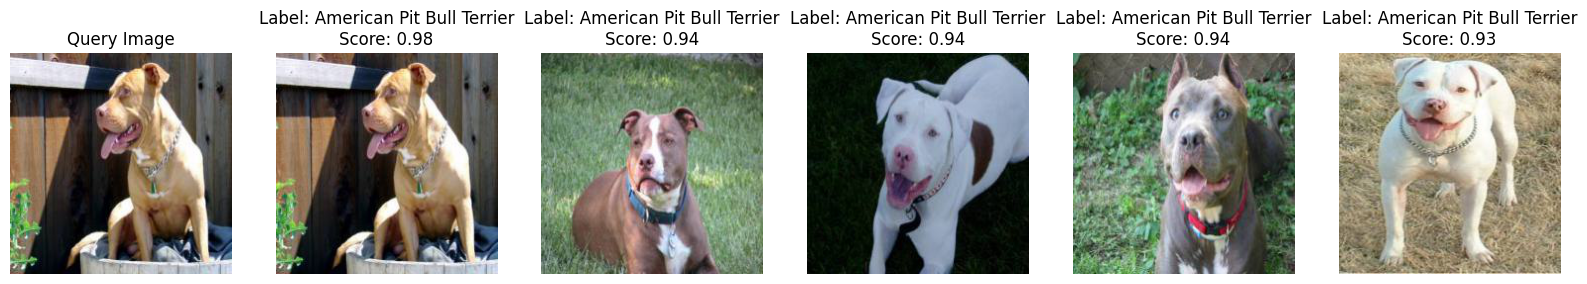

In [24]:
# Example search with a query image from the dataset
from random import randint
query_image, _ = subset[randint(0, 499)]
query_image = transforms.ToPILImage()(query_image)  # Convert tensor to PIL image
query_image_path = "./query_image.jpg"  # Save the query image to this path
query_image.save(query_image_path)  # Save the PIL image to the specified path

query_result = search_similar_images(query_image_path)

# Display the results
display_images(query_image_path, query_result)

In [26]:
def fetch_all_data():
    response = requests.get(
        f"{ES_HOST}/{ES_INDEX}/_search?size=1000",
        headers={"Content-Type": "application/json"},
        auth=(ES_USER, ES_PASS)
    )
    return response.json()

# Fetch and print all data
all_data = fetch_all_data()
for hit in all_data['hits']['hits']:
    print(f"ID: {hit['_id']}, Label: {hit['_source']['label']}, Name: {hit['_source']['name']}, vector: {hit['_source']['vector']}")


ID: 0, Label: Abyssinian, Name: image_0, vector: [-0.0008816922199912369, -0.005972833838313818, 0.03269892558455467, 0.026299895718693733, -0.012062654830515385, -0.0019419773016124964, 0.02153598703444004, 0.007428925018757582, 0.013188336975872517, 0.044445596635341644, -0.006588400341570377, -0.04523104056715965, 0.05155987665057182, 0.02324743941426277, 0.002444962505251169, 0.04455575719475746, 0.01668548956513405, -0.026837058365345, -0.0057039279490709305, 0.03987174481153488, -0.1364598572254181, -0.027171149849891663, 0.059442006051540375, 0.007756874430924654, -0.005255081690847874, 0.03482944145798683, 0.0019132305169478059, 0.029413949698209763, -0.03588865324854851, 0.0006265047704800963, -0.033374786376953125, 0.04129171371459961, 0.025851551443338394, -0.0038119161035865545, 0.007183626759797335, 0.023365966975688934, 0.003004389349371195, -0.004707843530923128, -0.02113485336303711, 0.0976511538028717, -0.006309415679425001, -0.038170941174030304, -0.03769991174340248,